<a href="https://colab.research.google.com/github/DeathSlayer1707/Gpt_model/blob/main/GPT_model_for_language_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

text_file = tf.keras.utils.get_file(
    fname = "fra-eng.zip"
    ,origin = "http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip"
    ,extract = True
)

3423204/3423204 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


To use the file, we use pathlib to extract from zip file


In [ ]:
import pathlib

# Defining the path to the text file
text_file = pathlib.Path('/root/.keras/datasets/fra-eng_extracted/fra.txt')

# Read and normalize the text pairs
with open(text_file) as fp:
    text_pair = [line for line in fp]

# Print the first 10 normalized text pairs to verify
for i in range(10):
    print(text_pair[i])

Go.	Va !

Hi.	Salut !

Run!	Cours !

Run!	Courez !

Who?	Qui ?

Wow!	Ça alors !

Fire!	Au feu !

Help!	À l'aide !

Jump.	Saute.

Stop!	Ça suffit !



In [ ]:
import random

for _ in range(5):
    print(random.choice(text_pair))

It rained nonstop.	Il a plu sans arrêt.

You were late for work.	Vous étiez en retard au travail.

Tom and Mary are older than John.	Tom et Mary sont plus vieux que John.

The crowd applauded.	La foule applaudit.

Did you love Tom?	Aimais-tu Tom ?



# **Embedding Layer**

Now we will be processing the data, and we will be using unicode


In [ ]:
import unicodedata  # Corrected module name
import re         #to clean the data

def normalize(line):

    # Normalize unicode characters, strip leading/trailing whitespace, convert to lowercase
    line  = unicodedata.normalize('NFKC', line.strip().lower()) # Using unicodedata

    # Handle special characters and add start and end tokens for the target language (French)
    line = re.sub(r"^([^ \w])(?!\s)", r"\1", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1", line)
    line = re.sub(r"(?!\s)([^ \w])$", r"\1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r"\1", line)
    eng, fre = line.split("\t")
    fre = '[start] ' + fre + ' [end]'
    return eng, fre

In [ ]:
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

In [ ]:
for _ in range(5):
    print(random.choice(text_pair))

How can you not know?	Comment parviens-tu à l'ignorer ?

She cleaned her room in a hurry.	Elle nettoya sa chambre en vitesse.

It isn't very interesting.	Ce n'est pas très intéressant.

Give me a reason to stay.	Donne-moi une raison de rester.

They're right, of course.	Ils ont raison, bien sûr.



In [ ]:
# Tokenization and Statistics

# Initialize sets to store unique tokens for English and French
eng_tokens, fre_tokens = set(), set()
# Initialize variables to store maximum sequence lengths
eng_maxlen, fre_maxlen = 0, 0

# Iterate through text pairs to tokenize and compute statistics
for eng, fre in text_pairs:
    eng_token, fre_token = eng.split(), fre.split()
    eng_maxlen = max(eng_maxlen, len(eng_token))
    fre_maxlen = max(fre_maxlen, len(fre_token))
    eng_tokens.update(eng_token)
    fre_tokens.update(fre_token)

# Print statistics
print(f"Total tokens in English: {len(eng_tokens)}")
print(f"Total tokens in French: {len(fre_tokens)}")
print(f"Maximum length of English sequence: {eng_maxlen}")
print(f"Maximum length of French sequence: {fre_maxlen}")

Total tokens in English: 25365
Total tokens in French: 42027
Maximum length of English sequence: 47
Maximum length of French sequence: 56


Pickle files are the dump files which we use to save our data.

In [ ]:
# Serialize preprocessed data for future use
import pickle

with open("text_pairs.pickle", 'wb') as fp:
    pickle.dump(text_pairs, fp)

Now we dont have to do the preprocessing again , we can directly use it in our saved format . this is the use of pickle file.

Now our next step would be to create the transformer model.
1. embedding layer
2. positional encoding
3. attention model

In [ ]:
import pickle
import random

with open("text_pairs.pickle", 'rb') as fp:
  text_pairs = pickle.load(fp)

In [ ]:
random.shuffle(text_pairs)

In [ ]:
# Split into train and test sets
n_val = int(0.15 * len(text_pairs))
n_train = len(text_pairs) - 2 * n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train: n_train + n_val]

In [ ]:
vocab_en = 10000
vocab_fr = 20000
seq_length = 25


In [ ]:
from tensorflow.keras.layers import TextVectorization
eng_vect = TextVectorization(
    max_tokens = vocab_en,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length
)

fre_vect = TextVectorization(
    max_tokens = vocab_fr,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length + 1
)

In [ ]:
train_eng = [pair[0]for pair in train_pair]
train_fre = [pair[1]for pair in train_pair]

In [ ]:
eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)

In [ ]:
with open('vectorize.pickle', 'wb') as fp:
    data = {'train': train_pair,
            'test': test_pair,
            'eng_vect': eng_vect.get_config(),
            'fre_vect': fre_vect.get_config(),
            'eng_weights': eng_vect.get_weights(),
            'fre_weights': fre_vect.get_weights()
            }
    pickle.dump(data, fp)

The reason to store in pickle file is so that we have a place to retrieve the data instead of keeping them in variable form.

In [ ]:
with open("vectorize.pickle", 'rb') as fp:
    data = pickle.load(fp)

Here we loading all the data into variables


In [ ]:
train_pair = data['train']
test_pair = data['test']

# Reconstruct TextVectorization layers
eng_vect = TextVectorization.from_config(data['eng_vect'])
eng_vect.set_weights(data['eng_weights'])
eng_vect.adapt([pair[0] for pair in train_pair]) # Re-adapt the English vectorization layer

fre_vect = TextVectorization.from_config(data['fre_vect'])
fre_vect.set_weights(data['fre_weights'])
fre_vect.adapt([pair[1] for pair in train_pair]) # Re-adapt the French vectorization layer

In [ ]:
# Define function to format dataset
def format_dataset(eng, fre):
    eng = eng_vect(eng)
    fre = fre_vect(fre)
    source = {'encode_inp': eng,
              'decode_inp': fre[:, :-1]
              }
    target = fre[:, 1:]

    return (source, target)

# Define function to create dataset
def make_dataset(pairs, batchsize=64):
    eng_text, fre_text = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))     # converting them to 3D arrays

    return dataset.shuffle(2048).batch(batchsize).map(format_dataset).prefetch(16)

In [ ]:
# Create TensorFlow datasets for training and testing
train_ds = make_dataset(train_pair)
test_ds = make_dataset(test_pair)

# **Positional Embedding**

In [ ]:
import numpy as np

# function to generate positional encoding matrix
def pos_enc_matrix(L, d, n=10000):
    assert d % 2 == 0
    d2 = d // 2

    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)
    i = np.arange(d2).reshape(1, -1)

    denom = np.power(n, -i / d2)
    args = k * denom

    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

In [ ]:
# Custom Keras layer for positional embedding
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        matrix = pos_enc_matrix(seq_length, embed_dim)

        self.positional_embedding = tf.constant(matrix, dtype='float32')

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.positional_embedding

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'seq_length': self.seq_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })

In [ ]:
# Usage and Validation
vocab_en = 10000
seq_length = 25

In [ ]:
# for inputs, targets in train_ds.take(1):
#     embed_en = PositionalEmbedding(seq_length, vocab_en, embed_dim=512)
#     en_emb = embed_en(inputs['encode_inp'])
#     print(en_emb._keras_mask)

# **Neural** **Networks**

**Self Attention Layer**: The self-attention mechanism allows our model to weigh the importance of different words within the same input sequence

In [ ]:
def self_attention(input_shape, prefix='att', mask=False, **kwargs):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in1")

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_att1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm1')
    add = tf.keras.layers.Add(name=f'{prefix}_add1')

    # Apply attention mechanism
    attout = attention(query=inputs, value=inputs, key=inputs, use_causal_mask=mask)

    # Apply normalization and residual connection
    output = norm(add([inputs, attout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f"{prefix}_att")

    return model

In [ ]:
seq_length = 25
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim), num_heads=num_heads, key_dim=key_dim)
model.summary()

Model: "att_att"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ att_in1             │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_att1            │ (None, 25, 128)   │    527,488 │ att_in1[0][0],    │
│ (MultiHeadAttentio… │                   │            │ att_in1[0][0],    │
│                     │                   │            │ att_in1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_add1 (Add)      │ (None, 25, 128)   │          0 │ att_in1[0][0],    │
│                     │                   │            │ att_att1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_norm1           │ (None, 25, 128)   │        256 │ att_add1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 527,744 (2.01 MB)

 Trainable params: 527,744 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

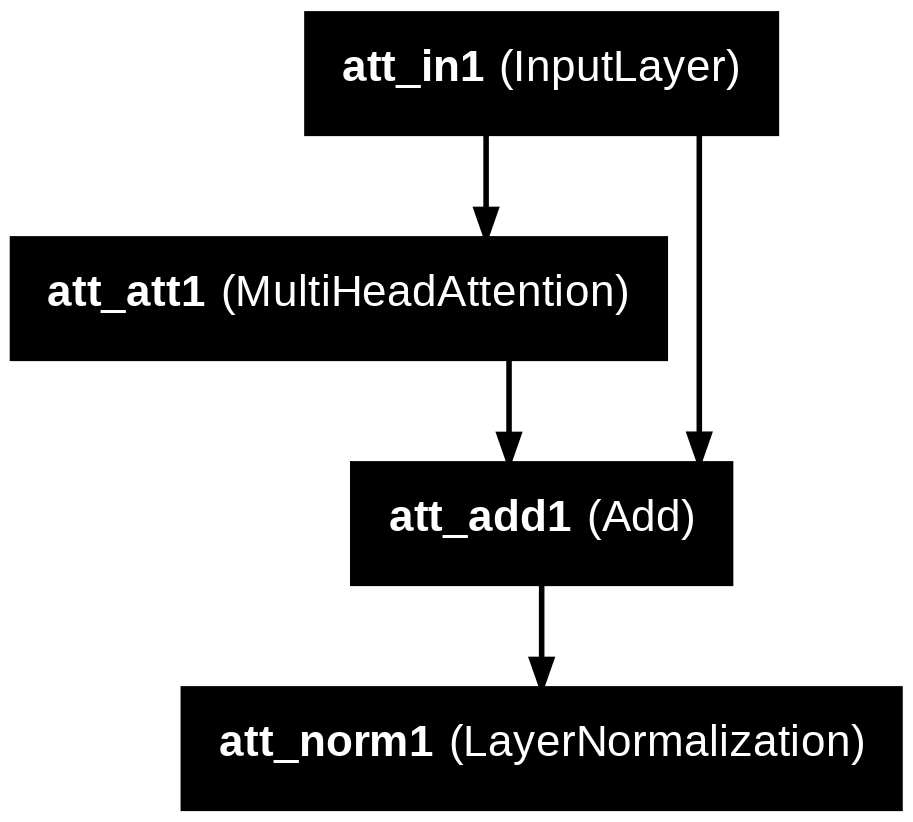

In [ ]:
tf.keras.utils.plot_model(model,show_layer_names= True)

**Cross Attention Layer** : The cross-attention layer enables our model to focus on relevant information from an external context, such as the source sentence in translation tasks.

In [ ]:
def cross_attention(input_shape, context_shape, prefix='att', **kwargs):
    # Define inputs
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32', name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in2')

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f'{prefix}_att2', **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm2')
    add = tf.keras.layers.Add(name=f'{prefix}_add2')

    # Apply attention mechanism
    attout = attention(query=inputs, key=context, value=context)

    # Apply normalization and residual connection
    output = norm(add([attout, inputs]))

    # Create the model
    model = tf.keras.Model(inputs=[context, inputs], outputs=output, name=f'{prefix}_crs_at')

    return model

In [ ]:
seq_length = 25
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim), context_shape=(seq_length, key_dim), num_heads=num_heads, key_dim=key_dim)
model.summary()

Model: "att_crs_at"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ att_ctx2            │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_in2             │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_att2            │ (None, 25, 128)   │    527,488 │ att_ctx2[0][0],   │
│ (MultiHeadAttentio… │                   │            │ att_in2[0][0],    │
│                     │                   │            │ att_ctx2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_add2 (Add)      │ (None, 25, 128)   │          0 │ att_att2[0][0],   │
│                     │                   │            │ att_in2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_norm2           │ (None, 25, 128)   │        256 │ att_add2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 527,744 (2.01 MB)

 Trainable params: 527,744 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

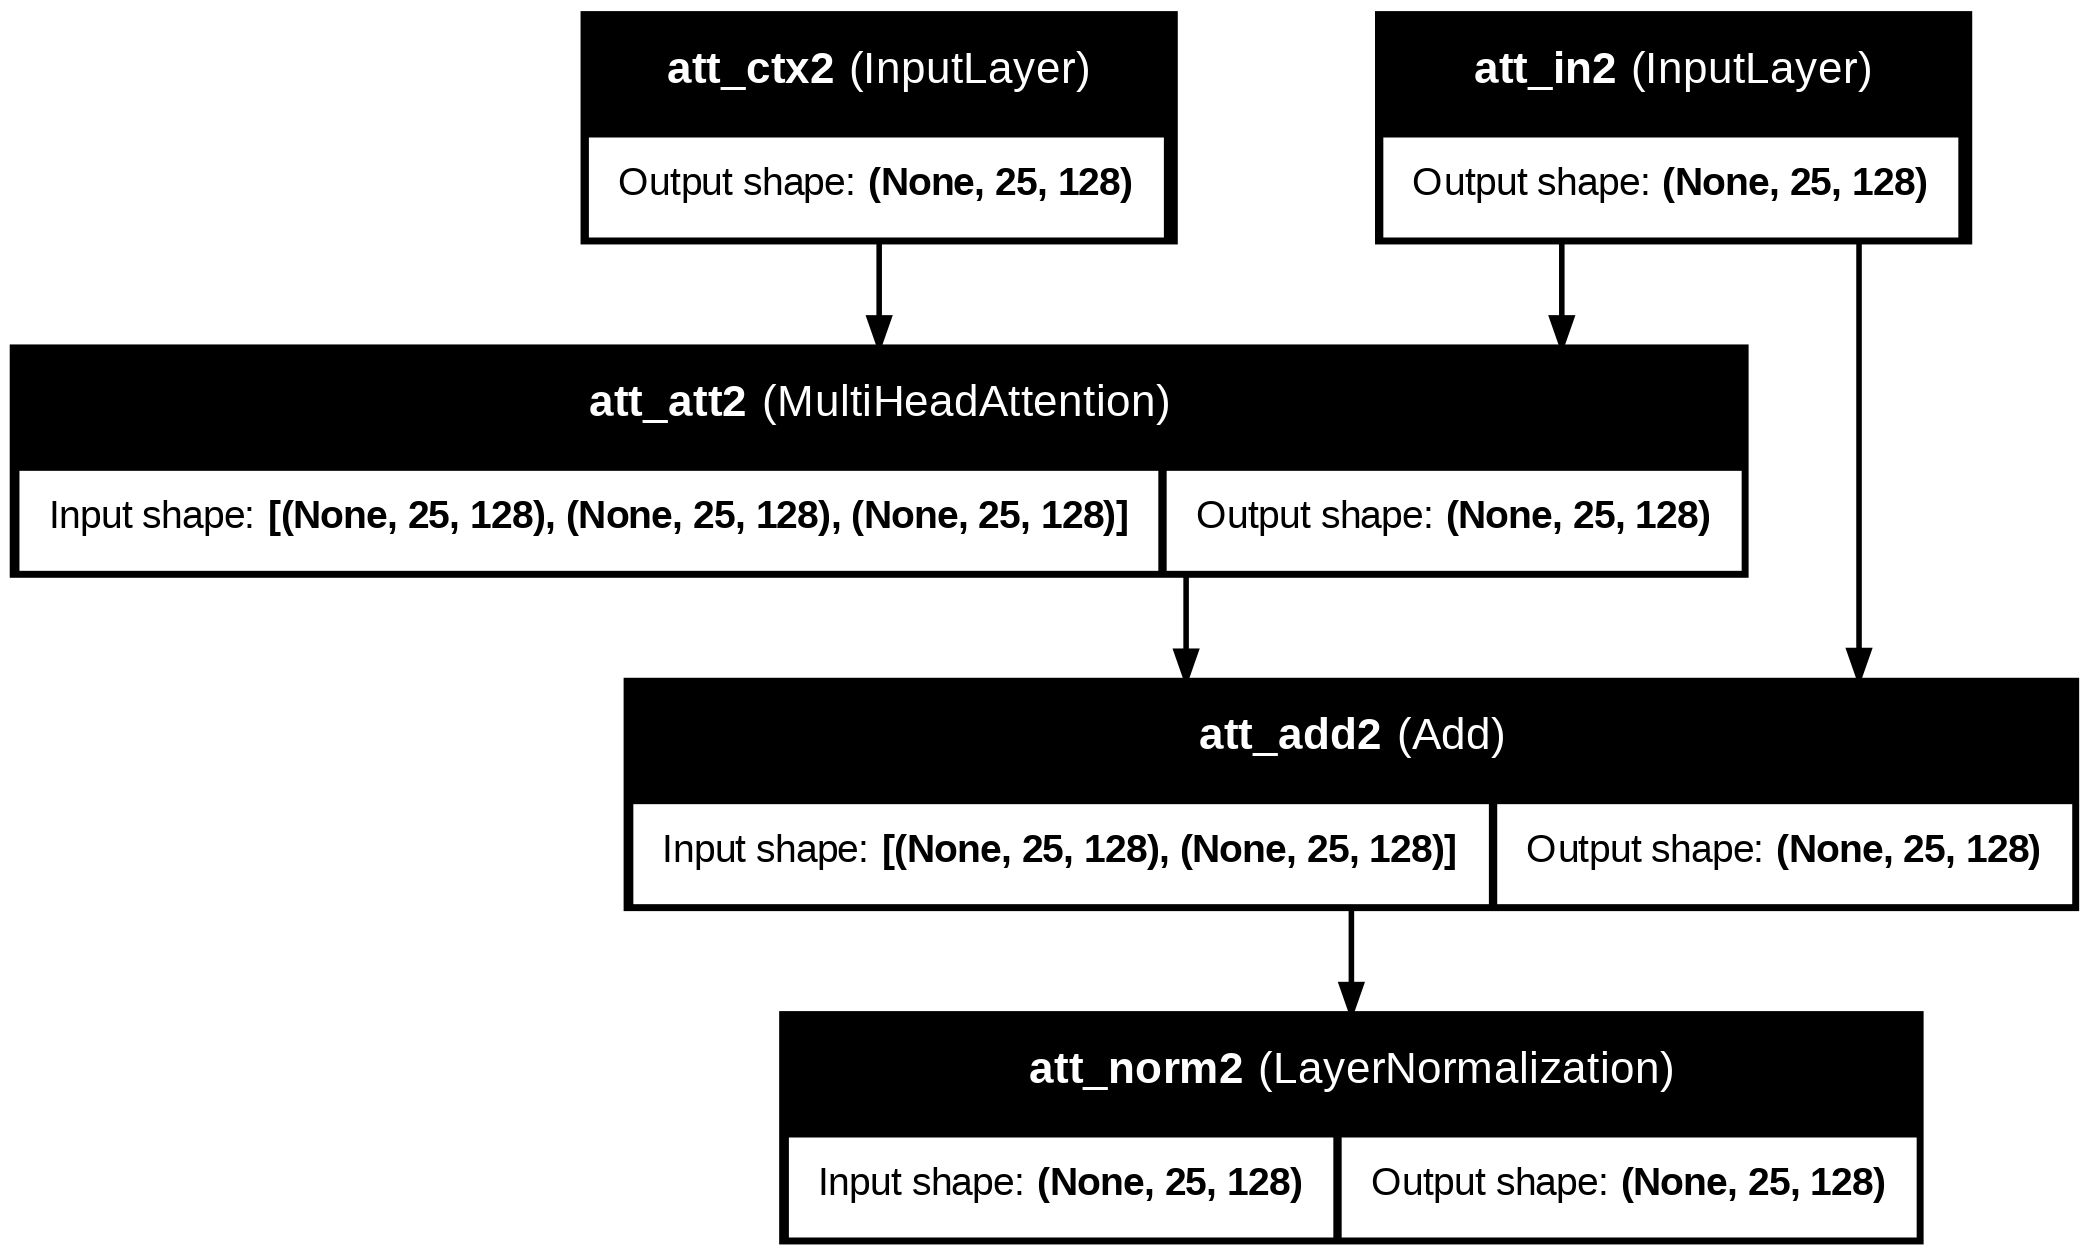

In [ ]:
tf.keras.utils.plot_model(model,show_layer_names= True,show_shapes = True)

**Feed-Forward Layer** : The feed-forward layer consists of two dense layers with a ReLU activation function, followed by dropout and layer normalization

In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=.1, prefix='ff'):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in3')

    # Dense layers
    dense1 = tf.keras.layers.Dense(ff_dim, name=f'{prefix}_ff1', activation='relu')
    dense2 = tf.keras.layers.Dense(model_dim, name=f'{prefix}_ff2')
    drop = tf.keras.layers.Dropout(dropout, name=f'{prefix}_drop')
    add = tf.keras.layers.Add(name=f"{prefix}_add3")

    # Apply feed-forward transformation
    ffout = drop(dense2(dense1(inputs)))

    # Layer normalization and residual connection
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm3')
    output = norm(add([inputs, ffout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f'{prefix}_ff')

    return model

In [ ]:
seq_length = 25
key_dim = 128
num_heads = 8
model_dim = 128 # Assuming model_dim is the same as key_dim based on usage context
ff_dim = 512 # A common value for the feed-forward dimension in transformers

model = feed_forward(input_shape=(seq_length, key_dim), model_dim=model_dim, ff_dim=ff_dim)
model.summary()

Model: "ff_ff"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ff_in3 (InputLayer) │ (None, 25, 128)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_ff1 (Dense)      │ (None, 25, 512)   │     66,048 │ ff_in3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_ff2 (Dense)      │ (None, 25, 128)   │     65,664 │ ff_ff1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_drop (Dropout)   │ (None, 25, 128)   │          0 │ ff_ff2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_add3 (Add)       │ (None, 25, 128)   │          0 │ ff_in3[0][0],     │
│                     │                   │            │ ff_drop[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_norm3            │ (None, 25, 128)   │        256 │ ff_add3[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,968 (515.50 KB)

 Trainable params: 131,968 (515.50 KB)

 Non-trainable params: 0 (0.00 B)

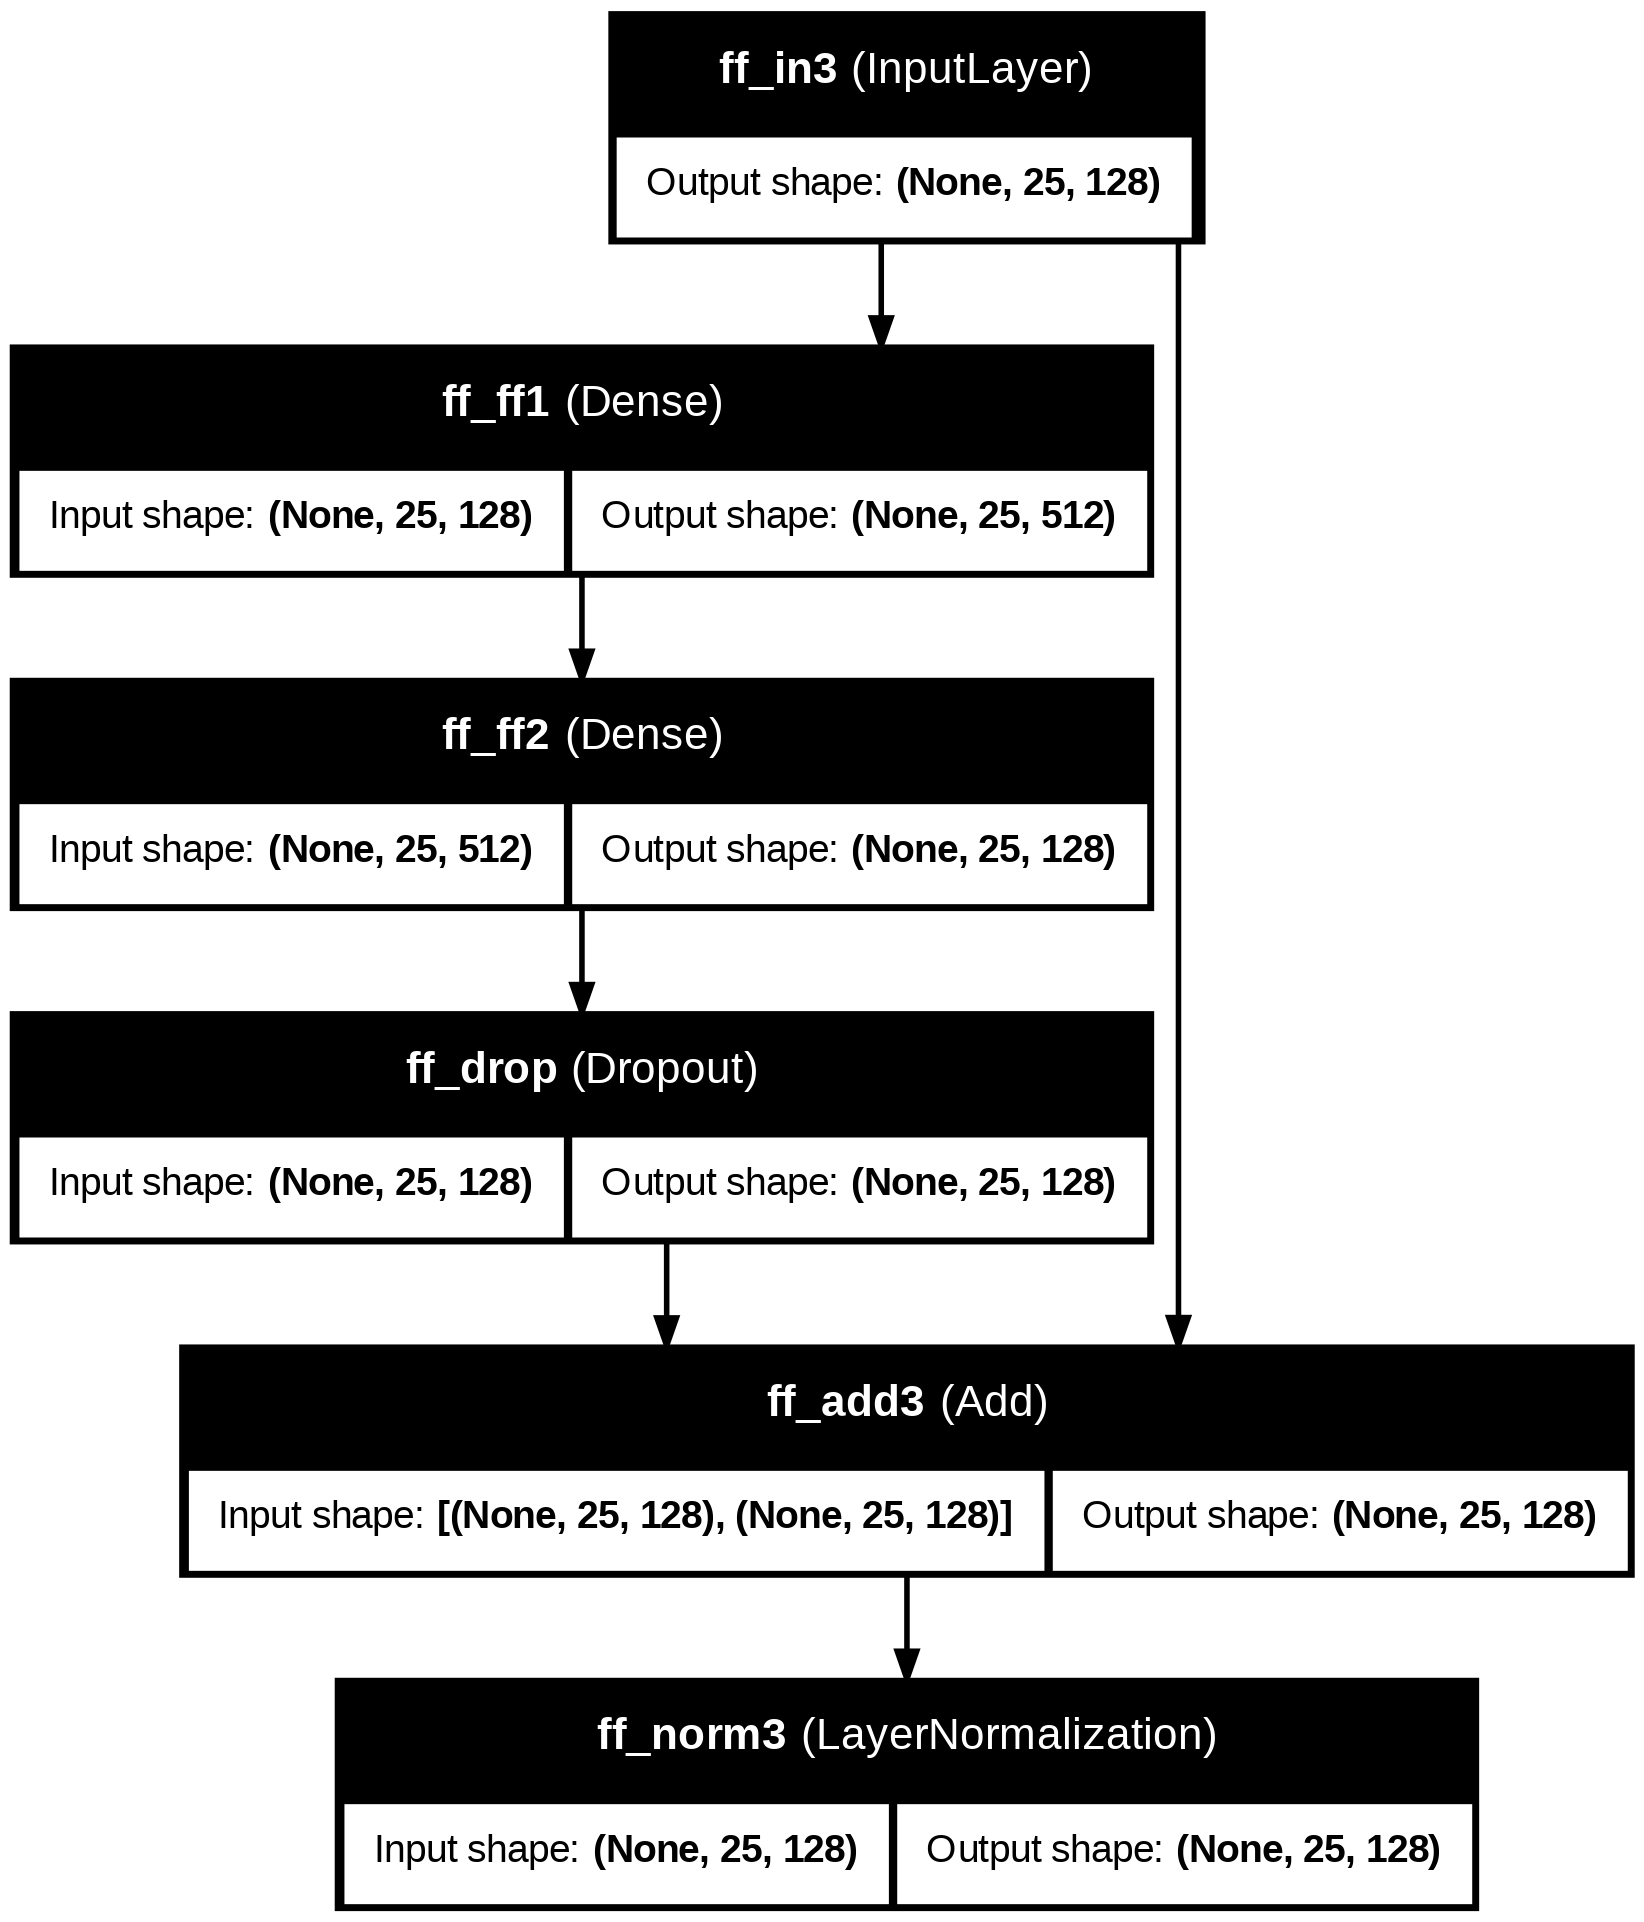

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

# **Encoder-decoder Architecture**

**Encoded Layer** : The encoder processes the input sequence and extracts meaningful representations. It consists of self-attention and feed-forward layer

In [ ]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='enc', **kwargs):
    # Define a Sequential model for the encoder
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0'), # Input layer
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs), # Self-attention layer
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix) # Feed-forward layer
    ])

    return model

In [ ]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8
model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,num_heads = num_heads)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_att (Functional)            │ (None, 25, 128)        │       527,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_ff (Functional)             │ (None, 25, 128)        │       131,968 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,712 (2.52 MB)

 Trainable params: 659,712 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

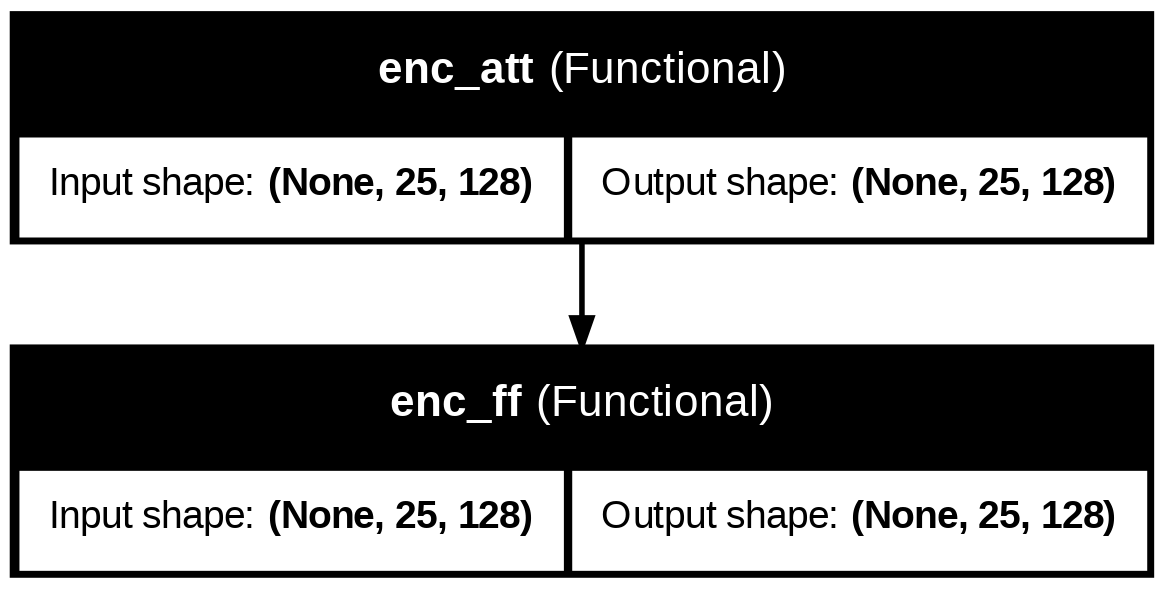

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

**Decoded Layer** : The decoder takes the encoder's output and generates the translated sequence. It comprises self-attention, cross-attention, and feed-forward layers.

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='dec', **kwargs):
    # Define inputs for decoder
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0')
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_ctx0')

    # Self-attention and cross-attention layers
    att_model = self_attention(input_shape, key_dim=key_dim, mask=True, prefix=prefix, **kwargs)
    cross_model = cross_attention(input_shape, input_shape, key_dim=key_dim, prefix=prefix, **kwargs)

     # Feed-forward layer
    ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    # Connect layers
    x = att_model(inputs)
    x = cross_model([context, x])
    output = ff_model(x)

    # Define decoder model
    model = tf.keras.Model(inputs=[inputs, context], outputs=output, name=prefix)

    return model

In [ ]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,num_heads = num_heads)
model.summary()

Model: "dec"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_in0             │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_ctx0            │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_att             │ (None, 25, 128)   │    527,744 │ dec_in0[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_crs_at          │ (None, 25, 128)   │    527,744 │ dec_ctx0[0][0],   │
│ (Functional)        │                   │            │ dec_att[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_ff (Functional) │ (None, 25, 128)   │    131,968 │ dec_crs_at[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,187,456 (4.53 MB)

 Trainable params: 1,187,456 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

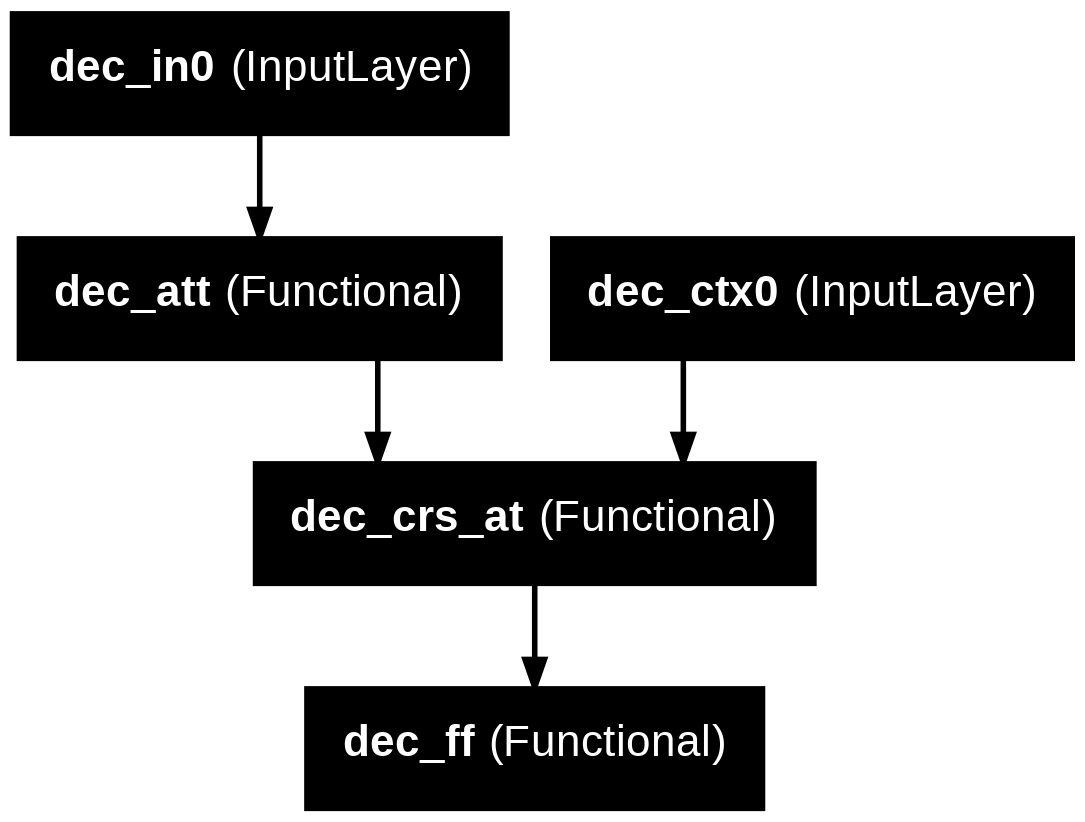

In [ ]:
tf.keras.utils.plot_model(model,show_shapes = False,show_layer_names = True)

**Transfer Model**: The transformer model combines the encoder and decoder to perform language translation

In [ ]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout=0.1, name='transformer'):
    # Define encoder and decoder inputs
    input_enc = tf.keras.layers.Input(shape=(seq_length,), dtype='int32', name='encode_inp')
    input_dec = tf.keras.layers.Input(shape=(seq_length,), dtype='int32', name='decode_inp')

    # Positional embeddings for encoder and decoder inputs
    emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name='embed_enc')
    emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name='embed_dec')

    # Create encoder and decoder layers
    encoders = [encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads)
                for i in range(num_layers)]

    # Final dense layer
    final = tf.keras.layers.Dense(vocab_size_fr, name='linear')

     # Apply encoder and decoder layers to inputs
    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])

    # Generate output
    output = final(x2)

    try:
        del output.keras_mask
    except:
        pass

    # Define transformer model
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)

    return model

In [ ]:
seq_length = 25
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

model = transformer(num_layers=num_layers, num_heads=num_heads, seq_length=seq_length, key_dim=key_dim, ff_dim=ff_dim, vocab_size_en=vocab_size_en, vocab_size_fr=vocab_size_fr, dropout=dropout)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


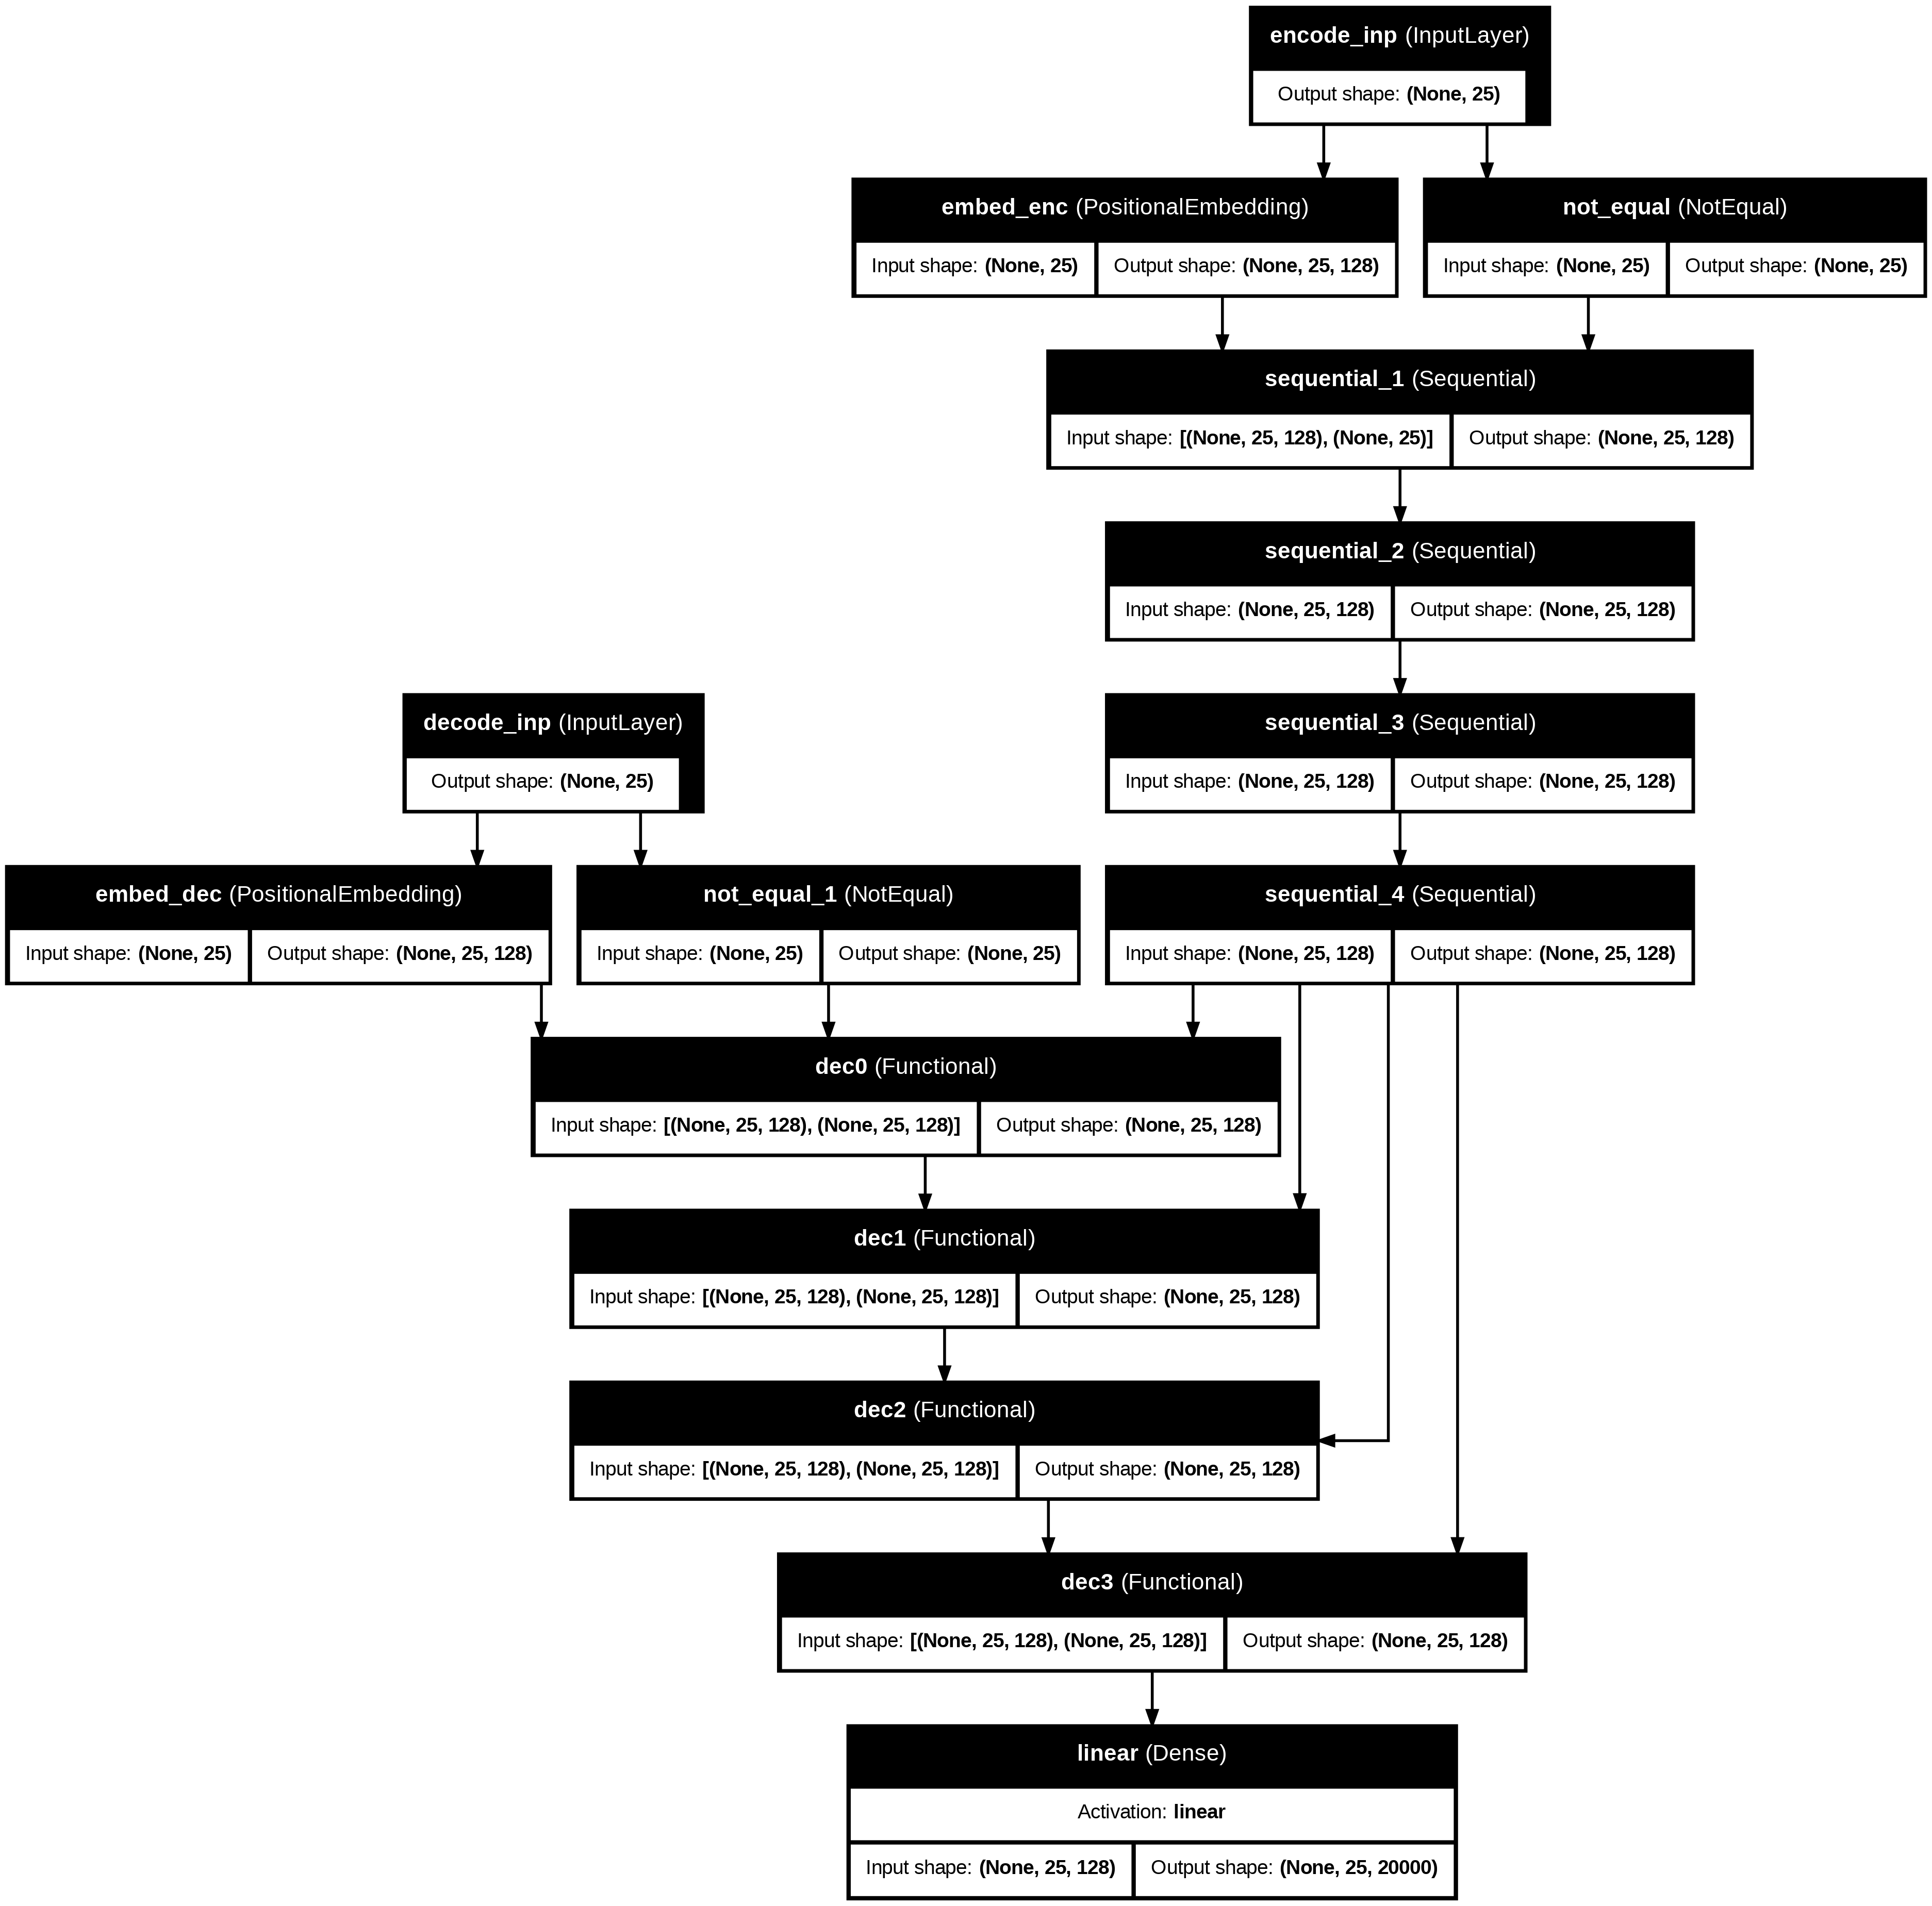

In [ ]:
tf.keras.utils.plot_model(model,show_layer_activations=True,show_layer_names=True,show_shapes=True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds,epochs = 20, validation_data  = test_ds)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

KeyboardInterrupt: 

# **Improving the model**

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps = 40000):

    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self,step):
    step = tf.cast(step , dtype = tf.float32)

    arg1 = tf.amth.rsqrt(step)
    arg2 = step*(self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1,arg2)

  def get_config(self):
    # Configuration for serialization
    config ={
      "key_dim": self.key_dim,
      "warmup_steps": self.warmup_steps
    }
    return config

# Define key dimension and create learning rate schedule
key_dim = 128
lr_schedule = CustomSchedule(key_dim)


**Masked Loss Function** :
To handle padded sequences during training . This function calculates the loss only for non-padded tokens in the input sequences.



In [ ]:
def masked_loss(label, pred):
  # Create mask for non-padded tokens
  mask = label != 0

  # Sparse categorical cross-entropy loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  # Apply mask to loss
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  # Compute average loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss

**Masked Accuracy Metric**: We define this to evaluate model performance while considering only non-padded tokens.


In [ ]:
def mask_accuracy(label, pred):
  # Convert predictions to class labels
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  # Calculate match between labels and predictions
  match = label == pred

  # Apply mask to match
  mask = label != 0
  match = match & mask

  # Compute accuracy
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [ ]:
model.compile(loss = masked_loss ,optimizer = 'adam' , metrics = [mask_accuracy])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# history = model.fit(train_ds , epochs = 20,validation_data = test_ds)

In [ ]:
# Just to visualize training accuracy


# import matplotlib.pyplot as plt

# # Visualizing Training History
# fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
# fig.suptitle('Training history')
# x = list(range(1, 21))  # Assuming 20 epochs
# axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
# axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
# axs[0].set_ylabel("Loss")
# axs[0].legend(loc="upper right")
# axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="mask_accuracy")
# axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_mask_accuracy")
# axs[1].set_ylabel("Accuracy")
# axs[1].set_xlabel("Epoch")
# axs[1].legend(loc="lower right")
# plt.show()

# **Testing the model**

In [ ]:
def translate(sentence):
    # Encode input sentence
    enc_tokens = eng_vect([sentence])
    lookup = list(fre_vect.get_vocabulary())
    start_sent, end_sent = "[start]", "[end]"
    output_sent = [start_sent]
    for i in range(seq_length):
        # Prepare decoder input
        vector = fre_vect([" ".join(output_sent)])
        assert vector.shape == (1, seq_length + 1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_length)
        # Generate predictions
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_length, vocab_size_fr)
        # Decode predicted token
        word = lookup[np.argmax(pred[0, i, :])]
        output_sent.append(word)
        if word == end_sent:
            break
    return output_sent


In [ ]:
# Test the model on sample test cases
test_count = 20
for n in range(test_count):
    eng_sent, fre_sent = random.choice(test_pair)
    translated = translate(eng_sent)
    print(f"Test case: {n}")
    print(f"English sentence: {eng_sent}")
    print(f"Translated sentence: {' '.join(translated)}")
    print(f"French sentence: {fre_sent}")
    print()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test case: 0
English sentence: admission was free.
Translated sentence: [start] [end]
French sentence: [start] l'entrée était gratuite. [end]

Test case: 1
English sentence: they are jealous of our success.
Translated sentence: [start] [end]
French sentence: [start] elles jalousent notre succès. [end]

Test case: 2
English sentence: in the first place, you should be punctual.
Translated sentence: [start] [end]
French sentence: [start] avant tout, soyez ponctuel ! [end]

Test case: 3
English sentence: she has a funny face.
Translated sentence: [start] [end]
French sentence: [start] elle a un drôle de visage. [end]

Test case: 4
English sentence: i'm pretty sure that this is tom's umbrella.
Translated sentence: [start] [end]
French sentence: [start] je suis pratiquement sûre que c'est le parapluie de tom. [end]

Test case: 5
English sentence: he read the poem in a monotone.
Translated sentence: [start] [end]
French sentence: [start] il a récité ce poème avec monotonie. [end]

Test case: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test case: 12
English sentence: as far as i know, he did nothing wrong.
Translated sentence: [start] [end]
French sentence: [start] pour autant que je sache, il n'a rien fait de mal. [end]

Test case: 13
English sentence: i've never met a musician that i didn't like.
Translated sentence: [start] [end]
French sentence: [start] je n'ai jamais rencontré un musicien que je n'aimais pas. [end]

Test case: 14
English sentence: tom sat in the darkness.
Translated sentence: [start] [end]
French sentence: [start] tom s'est assis dans l'obscurité. [end]

Test case: 15
English sentence: a fat man seldom dislikes anybody very hard or for very long.
Translated sentence: [start] [end]
French sentence: [start] un gros homme n'a jamais une très forte ou très longue aversion envers qui que ce soit. [end]



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test case: 16
English sentence: that movie was pretty boring.
Translated sentence: [start] [end]
French sentence: [start] ce film était plutôt ennuyant. [end]

Test case: 17
English sentence: he appeared from nowhere.
Translated sentence: [start] [end]
French sentence: [start] il est sorti de nulle part. [end]

Test case: 18
English sentence: that's not how you spell my name.
Translated sentence: [start] [end]
French sentence: [start] mon nom ne s'écrit pas comme ça. [end]

Test case: 19
English sentence: what's in there?
Translated sentence: [start] [end]
French sentence: [start] qu'y a-t-il là-dedans ? [end]

